In [ ]:
!pip install captum
!pip install -U kaleido # need to restart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 31.1 MB/s eta 0:00:00


### Load Libraries

In [ ]:
import torch
import pandas as pd
import numpy as np

from torch.nn.functional import softmax
import torch.nn.functional as F


from transformers import AutoTokenizer, AutoModelForSequenceClassification
from captum.attr import (IntegratedGradients,
                         LayerIntegratedGradients,
                         configure_interpretable_embedding_layer,
                         remove_interpretable_embedding_layer,
                         visualization)
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

from captum.attr import visualization as viz
import torch

In [ ]:
pd.set_option('display.max_colwidth', None)

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Data

In [ ]:
path = '/content/drive/MyDrive/Cineuropa_Project/'
df = pd.read_excel(path+'master0402024.xlsx')

In [ ]:
df_text = pd.read_csv(path+'reviews.csv')

In [ ]:
df_text['cineuropa_review_text'] = df_text['cineuropa_review_text'].astype(str)
df_text['variety_review_text'] = df_text['variety_review_text'].astype(str)
df_text['hollywoodreporter_review_text'] = df_text['hollywoodreporter_review_text'].astype(str)
df_text['screendaily_review_text'] = df_text['screendaily_review_text'].astype(str)

In [ ]:
def tokenize_and_create_df(row):
    text = row['cineuropa_review_text']
    if pd.notna(text) and isinstance(text, str):
        sentences = sent_tokenize(text)
        new_df_parsed_intermediate = pd.DataFrame(sentences, columns=["cineuropa_review_text"])
        new_df_parsed_intermediate["year"] = row["year"]
        new_df_parsed_intermediate["cineuropa_review_date"] = row["cineuropa_review_date"]
        new_df_parsed_intermediate["title"] = row["title"]
        new_df_parsed_intermediate["original_title"] = row["original_title"]
        new_df_parsed_intermediate["country"] = row["country"]
        new_df_parsed_intermediate["ID"] = row["ID"]
        return new_df_parsed_intermediate
    else:
        return pd.DataFrame()

In [ ]:
new_df_parsed = pd.concat(df_text.apply(tokenize_and_create_df, axis=1).tolist(), ignore_index=True, sort=False)

In [ ]:
labeled = pd.read_csv(path+"/Model_Output/Cineuropa_reviews.csv")
variety = pd.read_csv(path+"/Model_Output/Variety_reviews.csv")
hollywood = pd.read_csv(path+"/Model_Output/Hollywoodreporter_reviews.csv")
screendaily = pd.read_csv(path+"/Model_Output/Screendaily_reviews.csv")

In [ ]:
variety = variety.dropna()
hollywood = hollywood.dropna()
screendaily = screendaily.dropna()

### Connect to GPU

In [ ]:
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


### Run Model

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
model_name = "siebert/sentiment-roberta-large-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

In [ ]:
# Get sentences
sample_reviews = new_df_parsed['cineuropa_review_text'].sample(10, random_state=None)
print(sample_reviews)

40656    The scenes showing the subjects in action, moreover, are interspersed with diverse details and establishing shots (visually impeccable) depicting some of the more significant elements of the industrial area: the bulldozers in movement, the passing trucks on the asphalt, the greyness and fermentation on the buildings, the unsettling beauty of the lagoon sky with two gondoliers intent on rowing at the beginning of the film, etc.
36324                                                                                                                                                                                                                                                                                         It's an excellent debut, which proves the adage about not working with children in film is a fallacy when sufficient care is taken with the young actors.
88086                                                                                                                   

In [ ]:
# Encode the input sentence
text_batch = ["Life Guidance remains a successful film with an interesting theme that leaves the audience with some questions to take home",
              "It's a canny production which delivers a moral lesson, mixing the two perfectly and blending the spectacular with the intimate",
              "Marion Cotillard plays Sandra with an acting style that we've never seen in her before, endowing her with a convincing fragility",
              "It's not easy finding flaws in a film which so clearly bears the mark of its co-screenwriter Jaione Camborda",
              "The drama benefits from the insights and nuances begotten from the director’s personal experience",
              "It is classic storytelling that will delight those who like their dramas full of twists and turns, with pain and anger, in a film that highlights the changing position of women in society",
              "They manage to do something that is not always so easy: they are enjoyable, fun and interesting films",
              "The director has enlisted two fantastic actors to play them",
              "At its core, the movie escapes any coherent synopsis",
              "The idyllic nature of their life already suggests that something terrible will soon arrive to shatter that peace, and so it does",
              "Ultimately, however, despite multiple (perhaps even excessive) efforts in terms of mise en scène, the film's narrative minimalism and the story's over-optimistic spirit serve to dilute the force of the message directed at women"]

In [ ]:
# Define a forward function for Captum to work with logits directly
def forward_with_logits(input_ids, attention_mask):
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    return outputs.logits

# Use Layer Integrated Gradients for explanation (focusing on the embeddings layer)
lig = LayerIntegratedGradients(forward_with_logits, model.roberta.embeddings)

In [ ]:
def merge_tokens(tokens, attributions):
    """
    Merge subword tokens correctly and also merge their corresponding attributions.
    """
    merged_tokens = []
    merged_attributions = []

    current_token = ""
    current_attr_sum = 0

    for token, attr in zip(tokens, attributions):
        if token.startswith("Ġ"):
            if current_token:
                merged_tokens.append(current_token)
                merged_attributions.append(current_attr_sum)

            current_token = token[1:]  # Remove 'Ġ' used by RoBERTa to define new token
            current_attr_sum = attr  # Reset the attribution sum
        else:
            current_token += token
            current_attr_sum += attr

    # Add the final merged token
    if current_token:
        merged_tokens.append(current_token)
        merged_attributions.append(current_attr_sum)

    return merged_tokens, merged_attributions

In [ ]:
def mean_centered_scale(attributions):
    """
    Center the attributions around the mean and scale between [-1, 1].
    """
    mean_attr = np.mean(attributions)
    max_abs_attr = np.max(np.abs(attributions - mean_attr))

    # Avoid division by zero if max_abs_attr is zero
    if max_abs_attr == 0:
        return np.zeros_like(attributions)

    centered_attributions = (attributions - mean_attr) / max_abs_attr
    return centered_attributions

In [ ]:
def min_max_scale(attributions):
    """
    Scale attributions to be in the range [-1, 1].
    """
    min_attr = np.min(attributions)
    max_attr = np.max(attributions)

    # Avoid division by zero if min_attr and max_attr are equal
    if max_attr - min_attr == 0:
        return np.zeros_like(attributions)

    scaled_attributions = 2 * (attributions - min_attr) / (max_attr - min_attr) - 1
    return scaled_attributions

In [ ]:
def get_attributions(input_text):
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True)
    inputs = {key: value.to(device) for key, value in inputs.items()}

    output = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
    logits = output.logits  # Extract logits
    probs = F.softmax(logits, dim=1)  # Convert logits to probabilities

    pred_class = torch.argmax(logits, dim=1)
    pred_prob = probs[0, pred_class].item()  # Get predicted probability for the predicted class

    target_class = pred_class.item()

    # Compute attributions for input_ids
    attributions, delta = lig.attribute(inputs['input_ids'],
                                        additional_forward_args=(inputs['attention_mask'],),
                                        target=target_class,
                                        return_convergence_delta=True)

    # Convert token ids to tokens (with subword tokens)
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])

    # Sum the attributions across embedding dimensions
    token_attributions = attributions.sum(dim=-1).squeeze(0).detach().cpu().numpy()

    # Merge tokens and their corresponding attributions
    clean_tokens, clean_attributions = merge_tokens(tokens, token_attributions)

    return clean_tokens, clean_attributions, target_class, pred_prob

In [ ]:
def visualize_attributions_captum(tokens, attributions, target_class, sentence, pred_prob, method="min-max"):
    # Normalize attributions based on the chosen method
    if method == "min-max":
        norm_attributions = min_max_scale(attributions)
    elif method == "mean-centered":
        norm_attributions = mean_centered_scale(attributions)
    else:
        raise ValueError("Invalid normalization method. Choose 'min-max', 'mean-centered'.")

    # Prepare list of tokens and attributions for visualization
    token_list = [(token, norm_attr) for token, norm_attr in zip(tokens, norm_attributions)]

    # Use Captum's visualization library to display the attributions
    viz.visualize_text([viz.VisualizationDataRecord(
        word_attributions=norm_attributions,
        pred_prob=pred_prob,
        pred_class=("Positive" if target_class == 1 else "Negative"),
        true_class=None,
        attr_class=("Positive" if target_class == 1 else "Negative"),
        attr_score=np.sum(norm_attributions),
        raw_input_ids=tokens,
        convergence_score=None
    )])

In [ ]:
for sentence in text_batch:
    tokens, attributions, target_class, pred_prob = get_attributions(sentence)
    visualize_attributions_captum(tokens, attributions, target_class, sentence, pred_prob)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (1.00),Positive,3.35,Life Guidance remains a successful film with an interesting theme that leaves the audience with some questions to take home


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (1.00),Positive,2.69,"It's a canny production which delivers a moral lesson, mixing the two perfectly and blending the spectacular with the intimate"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (1.00),Positive,7.18,"Marion Cotillard plays Sandra with an acting style that we've never seen in her before, endowing her with a convincing fragility"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Negative (1.00),Negative,0.48,It's not easy finding flaws in a film which so clearly bears the mark of its co-screenwriter Jaione Camborda


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (1.00),Positive,2.06,The drama benefits from the insights and nuances begotten from the directorâĢĻs personal experience


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (1.00),Positive,4.03,"They manage to do something that is not always so easy: they are enjoyable, fun and interesting films"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (1.00),Positive,-4.03,The director has enlisted two fantastic actors to play them


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Negative (1.00),Negative,-5.94,"At its core, the movie escapes any coherent synopsis"


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
None,Positive (0.99),Positive,-7.11,"The idyllic nature of their life already suggests that something terrible will soon arrive to shatter that peace, and so it does"


In [ ]:
def change_apostrophes(s):
    if pd.isna(s):
        return s
    return s.replace("’", "'")

In [ ]:
# Remove apostrophes from the 'text' column
labeled['text_cleaned'] = labeled['text'].apply(change_apostrophes)
variety['text_cleaned'] = variety['text'].apply(change_apostrophes)
hollywood['text_cleaned'] = hollywood['text'].apply(change_apostrophes)
screendaily['text_cleaned'] = screendaily['text'].apply(change_apostrophes)

In [ ]:
len(hollywood)

47303

In [ ]:
mask_labeled = labeled['text_cleaned'].str.contains('|'.join(text_batch), case=False, na=False)
#mask_variety = variety['text_cleaned'].str.contains('|'.join(text_batch), case=False, na=False)
#mask_hollywood = hollywood['text_cleaned'].str.contains('|'.join(text_batch), case=False, na=False)
#mask_screendaily = screendaily['text_cleaned'].str.contains('|'.join(text_batch), case=False, na=False)

# Print the entire rows that contain the search strings
matching_rows_labaled = labeled[mask_labeled]

#matching_rows_variety = variety[mask_variety]
#matching_rows_hollywood = hollywood[mask_hollywood]
#matching_rows_screendaily = screendaily[mask_screendaily]

<ipython-input-33-c7527f56baf9>:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_labeled = labeled['text_cleaned'].str.contains('|'.join(text_batch), case=False, na=False)


Compare with labeled data frame

In [ ]:
matching_rows_labaled

,Unnamed: 0,text,Predicted Sentiment,Sentiment (Probabilities),cineuropa_review_text,year,cineuropa_review_date,title,original_title,country,ID,Sentence_Rank,text_cleaned
1,1,"They manage to do something that is not always so easy: they are enjoyable, fun and interesting films.",1,"tf.Tensor([0.00106313 0.99893683], shape=(2,), dtype=float32)","They manage to do something that is not always so easy: they are enjoyable, fun and interesting films.",2022,11/10/2022,The Innocent,L'Innocent,France,1,1.0,"They manage to do something that is not always so easy: they are enjoyable, fun and interesting films."
16501,16501,The director has enlisted two fantastic actors to play them.,1,"tf.Tensor([0.00125441 0.99874556], shape=(2,), dtype=float32)",The director has enlisted two fantastic actors to play them.,2021,04/09/2021,Dark Heart of the Forest,Le coeur noir des forêts,"Belgium, France",825,21.0,The director has enlisted two fantastic actors to play them.
26035,26035,It’s not easy finding flaws in a film which so clearly bears the mark of its co-screenwriter Jaione Camborda.,0,"tf.Tensor([0.99828315 0.00171685], shape=(2,), dtype=float32)",It’s not easy finding flaws in a film which so clearly bears the mark of its co-screenwriter Jaione Camborda.,2020,13/11/2020,Ons,Ons,"Spain, Portugal",1334,11.0,It's not easy finding flaws in a film which so clearly bears the mark of its co-screenwriter Jaione Camborda.
26383,26383,"At its core, the movie escapes any coherent synopsis.",0,"tf.Tensor([9.994809e-01 5.190975e-04], shape=(2,), dtype=float32)","At its core, the movie escapes any coherent synopsis.",2020,03/11/2020,Zaho Zay,Zaho Zay,"Austria, France, Madagascar",1354,15.0,"At its core, the movie escapes any coherent synopsis."
39960,39960,"The idyllic nature of their life already suggests that something terrible will soon arrive to shatter that peace, and so it does.",0,"tf.Tensor([0.97824746 0.02175253], shape=(2,), dtype=float32)","The idyllic nature of their life already suggests that something terrible will soon arrive to shatter that peace, and so it does.",2019,12/09/2019,Ordinary Love,Ordinary Love,United Kingdom,2083,4.0,"The idyllic nature of their life already suggests that something terrible will soon arrive to shatter that peace, and so it does."
44426,44426,"It is classic storytelling that will delight those who like their dramas full of twists and turns, with pain and anger, in a film that highlights the changing position of women in society.",1,"tf.Tensor([0.00107787 0.9989221 ], shape=(2,), dtype=float32)","It is classic storytelling that will delight those who like their dramas full of twists and turns, with pain and anger, in a film that highlights the changing position of women in society.",2019,24/05/2019,The Invisible Life of Eurídice Gusmão,A Vida Invisível de Eurídice Gusmão,"Brazil, Germany",2307,20.0,"It is classic storytelling that will delight those who like their dramas full of twists and turns, with pain and anger, in a film that highlights the changing position of women in society."
45744,45744,"It’s a canny production which delivers a moral lesson, mixing the two perfectly and blending the spectacular with the intimate.",1,"tf.Tensor([0.00107042 0.99892956], shape=(2,), dtype=float32)","It’s a canny production which delivers a moral lesson, mixing the two perfectly and blending the spectacular with the intimate.",2019,18/04/2019,The Champion,Il Campione,Italy,2378,3.0,"It's a canny production which delivers a moral lesson, mixing the two perfectly and blending the spectacular with the intimate."
63890,63890,Life Guidance remains a successful film with an interesting theme that leaves the audience with some questions to take home.,1,"tf.Tensor([0.00108666 0.9989134 ], shape=(2,), dtype=float32)",Life Guidance remains a successful film with an interesting theme that leaves the audience with some questions to take home.,2017,09/09/2017,Life Guidance,Life Guidance,Austria,3406,14.0,Life Guidance remains a succ

### All Data

In [ ]:
'''
def get_attributions_for_dataframe(df, text_column='text_cleaned'):
    all_clean_tokens = []
    all_clean_attributions = []
    all_pred_classes = []
    all_pred_probs = []

    for index, row in df.iterrows():
        sentence = row[text_column]
        clean_tokens, clean_attributions, pred_class, pred_prob = get_attributions(sentence)

        # Append to the lists for later aggregation
        all_clean_tokens.append(clean_tokens)
        all_clean_attributions.append(clean_attributions)
        all_pred_classes.append(pred_class)
        all_pred_probs.append(pred_prob)

    return all_clean_tokens, all_clean_attributions, all_pred_classes, all_pred_probs

# Apply to entire DataFrame
all_tokens, all_attributions, all_pred_classes, all_pred_probs = get_attributions_for_dataframe(screendaily.iloc[:25000,:])
'''

In [ ]:
import os
import pickle

pickle_cineuropa = os.path.join(path, 'attributions_cineuropa.pkl')
pickle_variety = os.path.join(path, 'attributions_variety.pkl')
pickle_hollywood = os.path.join(path, 'attributions_hollywood.pkl')
pickle_screendaily = os.path.join(path, 'attributions_screendaily.pkl')

In [ ]:
#with open(pickle_screendaily, 'wb') as f:
#  pickle.dump((all_tokens, all_attributions, all_pred_classes, all_pred_probs), f)
#  print("Data computed and saved to pickle file.")

Data computed and saved to pickle file.


In [ ]:
def load_pickle_data(pickle_file):
    with open(pickle_file, 'rb') as f:
        all_tokens, all_attributions, all_pred_classes, all_pred_probs = pickle.load(f)
    return all_tokens, all_attributions, all_pred_classes, all_pred_probs

# Load data from each file
all_tokens_cineuropa, all_attributions_cineuropa, all_pred_classes_cineuropa, all_pred_probs_cineuropa = load_pickle_data(pickle_cineuropa)
print("Cineuropa loaded from pickle file.")

all_tokens_variety, all_attributions_variety, all_pred_classes_variety, all_pred_probs_variety = load_pickle_data(pickle_variety)
print("Variety loaded from pickle file.")

all_tokens_hollywood, all_attributions_hollywood, all_pred_classes_hollywood, all_pred_probs_hollywood = load_pickle_data(pickle_hollywood)
print("Hollywood loaded from pickle file.")

all_tokens_screendaily, all_attributions_screendaily, all_pred_classes_screendaily, all_pred_probs_screendaily = load_pickle_data(pickle_screendaily)
print("Screendaily loaded from pickle file.")

Cineuropa loaded from pickle file.
Variety loaded from pickle file.
Hollywood loaded from pickle file.
Screendaily loaded from pickle file.


In [ ]:
import string
import unicodedata


# Function to clean tokens by removing special tokens and punctuation
def clean_tokens(token_attribution_map):
    cleaned_map = {}

    stop_words = set(stopwords.words('english'))

    for token, attr in token_attribution_map.items():
        # Remove RoBERTa special tokens
        cleaned_token = token.replace("<s>", "").replace("</s>", "").replace(".", "").replace(",", "").replace("?", "").replace(":", "")
        cleaned_token = re.sub(r"[^a-zA-Z-']", "", cleaned_token)
        cleaned_token = ' '.join([word for word in cleaned_token.split() if len(word) <= 12])
        cleaned_token = cleaned_token.lower()

        # Skip if the token is empty after cleaning
        if not cleaned_token:
            continue

        # Skip stop words (case-insensitive)
        if cleaned_token in stop_words:
            continue

        # Add the cleaned token and its attribution to the cleaned map
        cleaned_map[cleaned_token] = attr

    return cleaned_map

In [ ]:
from collections import defaultdict
import re
import numpy as np

def aggregate_attributions_by_class(all_tokens, all_attributions, all_pred_classes):
    # Use two dictionaries to store cumulative attributions for each token
    positive_token_attribution_map = defaultdict(float)
    negative_token_attribution_map = defaultdict(float)

    # Aggregate attributions across all sentences based on predicted class
    for tokens, attributions, pred_class in zip(all_tokens, all_attributions, all_pred_classes):
        attributions = mean_centered_scale(attributions)
        for token, attribution in zip(tokens, attributions):
            if pred_class == 1:  # Positive prediction
                positive_token_attribution_map[token] += attribution
            else:  # Negative prediction
                negative_token_attribution_map[token] += attribution


    # Clean the tokens in both maps
    positive_token_attribution_map = clean_tokens(positive_token_attribution_map)
    negative_token_attribution_map = clean_tokens(negative_token_attribution_map)

    return positive_token_attribution_map, negative_token_attribution_map

# Aggregate attributions
positive_token_attribution_map_cineuropa, negative_token_attribution_map_cineuropa = aggregate_attributions_by_class(
    all_tokens_cineuropa, all_attributions_cineuropa, all_pred_classes_cineuropa
)

positive_token_attribution_map_variety, negative_token_attribution_map_variety = aggregate_attributions_by_class(
    all_tokens_variety, all_attributions_variety, all_pred_classes_variety
)

positive_token_attribution_map_hollywood, negative_token_attribution_map_hollywood = aggregate_attributions_by_class(
    all_tokens_hollywood, all_attributions_hollywood, all_pred_classes_hollywood
)

positive_token_attribution_map_screendaily, negative_token_attribution_map_screendaily = aggregate_attributions_by_class(
    all_tokens_screendaily, all_attributions_screendaily, all_pred_classes_screendaily
)

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_top_tokens_by_class(positive_token_maps, negative_token_maps, top_n=10):
    num_instances = len(positive_token_maps)

    # Create subplots; we need num_instances rows and 2 columns (for positive and negative)
    fig = make_subplots(rows=num_instances, cols=2, subplot_titles=['Positive Contributions', 'Negative Contributions'])

    for i, (positive_token_map, negative_token_map) in enumerate(zip(positive_token_maps, negative_token_maps)):
        # Sort and get top N tokens for both positive and negative contributions
        top_positive_tokens = sorted(positive_token_map.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_negative_tokens = sorted(negative_token_map.items(), key=lambda x: x[1], reverse=True)[:top_n]

        # Extract tokens and their attributions (reverse to have the most frequent on top)
        positive_tokens, positive_attributions = zip(*top_positive_tokens)
        negative_tokens, negative_attributions = zip(*top_negative_tokens)

        # Reverse the order so that most frequent is on top in the bar chart
        positive_tokens = positive_tokens[::-1]
        positive_attributions = positive_attributions[::-1]
        negative_tokens = negative_tokens[::-1]
        negative_attributions = negative_attributions[::-1]

        # Add positive contributions (green) to the first column
        fig.add_trace(
            go.Bar(x=positive_attributions, y=positive_tokens, orientation='h', marker=dict(color='#f4b191')),
            row=i + 1, col=1
        )

        # Add negative contributions (red) to the second column
        fig.add_trace(
            go.Bar(x=negative_attributions, y=negative_tokens, orientation='h', marker=dict(color='#70284a')),
            row=i + 1, col=2
        )

    # Update layout for better appearance
    fig.update_layout(
        height=num_instances * 300,  # Adjust height based on number of rows
        showlegend=False,
        title_text=None,
        title_x=0.5,
        plot_bgcolor='white',
    )

    fig.update_xaxes(showgrid=False, linecolor='black')
    fig.update_yaxes(showgrid=False, linecolor='black')

    fig.show()
    fig.write_image(path+"Aggregate_Token_Attributions.pdf")

# Example token maps (replace these with actual data)
positive_token_maps = [positive_token_attribution_map_cineuropa,
                       positive_token_attribution_map_variety,
                       positive_token_attribution_map_hollywood,
                       positive_token_attribution_map_screendaily]
negative_token_maps = [negative_token_attribution_map_cineuropa,
                       negative_token_attribution_map_variety,
                       negative_token_attribution_map_hollywood,
                       negative_token_attribution_map_screendaily]

# Plot top tokens by class (positive and negative)
plot_top_tokens_by_class(positive_token_maps,
                         negative_token_maps,
                         top_n=10)

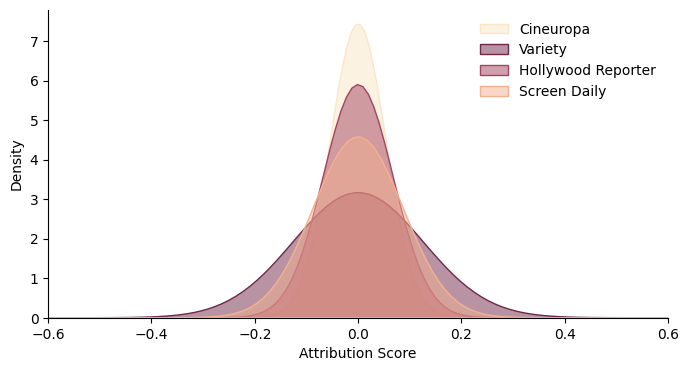

In [ ]:
import seaborn as sns
# Flatten all attributions into one list
all_attributions_flat_cineuropa = [attr for attributions in all_attributions_cineuropa for attr in attributions]
all_attributions_flat_variety = [attr for attributions in all_attributions_variety for attr in attributions]
all_attributions_flat_hollywood = [attr for attributions in all_attributions_hollywood for attr in attributions]
all_attributions_flat_screendaily = [attr for attributions in all_attributions_screendaily for attr in attributions]

# Normalize the attributions to the range [-1, 1]
normalized_attributions_cineuropa = mean_centered_scale(np.array(all_attributions_flat_cineuropa))
normalized_attributions_variety = mean_centered_scale(np.array(all_attributions_flat_variety))
normalized_attributions_hollywood  = mean_centered_scale(np.array(all_attributions_flat_hollywood))
normalized_attributions_screendaily = mean_centered_scale(np.array(all_attributions_flat_screendaily))

# Create a density plot of the normalized attribution scores
plt.figure(figsize=(8, 4))
sns.kdeplot(normalized_attributions_cineuropa, color='#fbe6c5',
            fill=True, alpha=0.5, bw_adjust=250.0, label='Cineuropa')  # Increase bandwidth for smoother curve
sns.kdeplot(normalized_attributions_variety, color='#70284a',
            fill=True, alpha=0.5, bw_adjust=250.0, label='Variety')
sns.kdeplot(normalized_attributions_hollywood, color='#a44360',
            fill=True, alpha=0.5, bw_adjust=250.0, label='Hollywood Reporter')
sns.kdeplot(normalized_attributions_screendaily, color='#f4b191',
            fill=True, alpha=0.5, bw_adjust=250.0, label='Screen Daily')
plt.xlim(-.6, .6)
plt.xlabel("Attribution Score")
plt.legend(title=None, frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.ylabel("Density")
plt.savefig(path+"KDE_agg_attributions.pdf", dpi=300, bbox_inches='tight')
plt.show()